In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# processamento dos dados e avaliaçao dos modelos
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

# modelos
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
#padroniza valores pandas
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
df = pd.read_csv("internet_service_churn.csv")
df.head(3)

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,15,1,0,11.95,25,0.14,0,8.40,2.30,0,0
1,18,0,0,8.22,0,NaN,0,0.00,0.00,0,1
2,23,1,0,8.91,16,0.00,0,13.70,0.90,0,1


# Analise dos dados

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72274 entries, 0 to 72273
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           72274 non-null  int64  
 1   is_tv_subscriber             72274 non-null  int64  
 2   is_movie_package_subscriber  72274 non-null  int64  
 3   subscription_age             72274 non-null  float64
 4   bill_avg                     72274 non-null  int64  
 5   reamining_contract           50702 non-null  float64
 6   service_failure_count        72274 non-null  int64  
 7   download_avg                 71893 non-null  float64
 8   upload_avg                   71893 non-null  float64
 9   download_over_limit          72274 non-null  int64  
 10  churn                        72274 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 6.1 MB


In [4]:
# 1.1 assinalando variaveis nulas como 0, pois todas elas sao plausiveis de assumir que apenas nao houve o primeiro input, como 
# ... por exemplo o tempo de contrato restante, que é possivel que nao exista contrato, ou que o usuario nao tenha download 
# ... medio por ser o primeiro mes com o serviço ou que nunca usou
df.reamining_contract = np.where(df['reamining_contract'].isnull(), 0, df['reamining_contract'])
df.download_avg = np.where(df['download_avg'].isnull(), 0, df['download_avg'])
df.upload_avg = np.where(df['upload_avg'].isnull(), 0, df['upload_avg'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72274 entries, 0 to 72273
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           72274 non-null  int64  
 1   is_tv_subscriber             72274 non-null  int64  
 2   is_movie_package_subscriber  72274 non-null  int64  
 3   subscription_age             72274 non-null  float64
 4   bill_avg                     72274 non-null  int64  
 5   reamining_contract           72274 non-null  float64
 6   service_failure_count        72274 non-null  int64  
 7   download_avg                 72274 non-null  float64
 8   upload_avg                   72274 non-null  float64
 9   download_over_limit          72274 non-null  int64  
 10  churn                        72274 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 6.1 MB


In [7]:
# base disponivel é um sample de uma base maior
df.id.max(), df.shape[0]

(1689744, 72274)

<AxesSubplot:xlabel='churn', ylabel='count'>

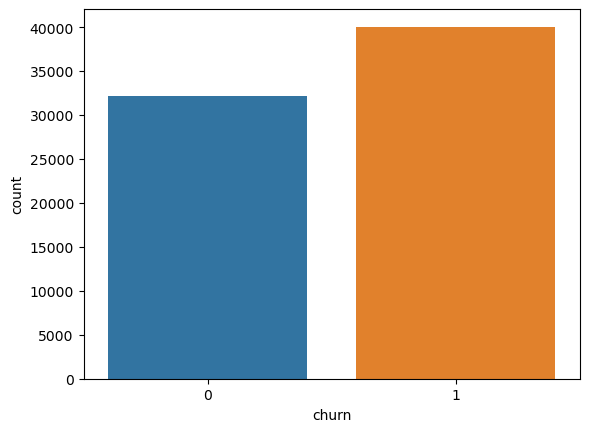

In [8]:
# base possui mais churns do que clientes atuais
sns.countplot(df.churn)

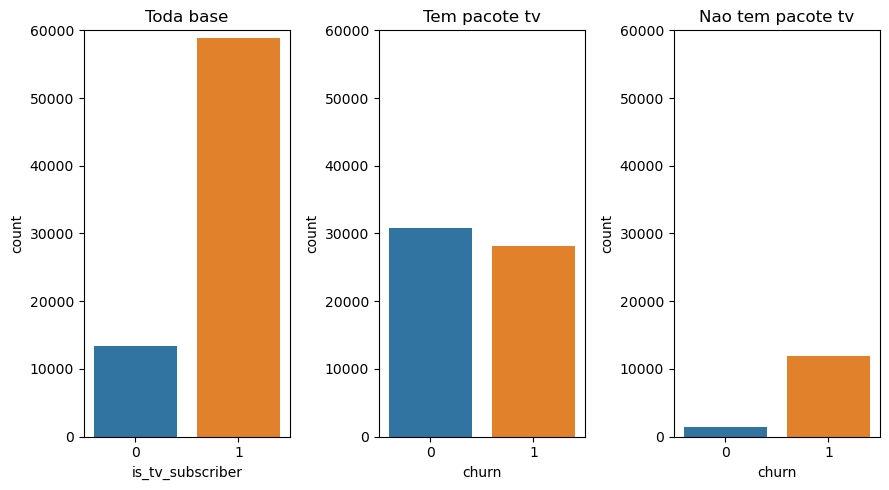

In [56]:
# 1.1 grande maioria das pessoas assinam tv
# 1.2 maioria das pessoas que nao assinam tv acabam dando churn, numero é equilibrado quando assinam tv
f, ax = plt.subplots(1, 3, figsize=(9, 5))
sns.countplot(df.is_tv_subscriber, ax=ax[0])
ax[0].set_ylim(0, 60000)
ax[0].set_title('Toda base')
sns.countplot(df[df.is_tv_subscriber == 1].churn, ax=ax[1])
ax[1].set_ylim(0, 60000)
ax[1].set_title('Tem pacote tv')
sns.countplot(df[df.is_tv_subscriber == 0].churn, ax=ax[2])
ax[2].set_ylim(0, 60000)
ax[2].set_title('Nao tem pacote tv')
f.tight_layout()

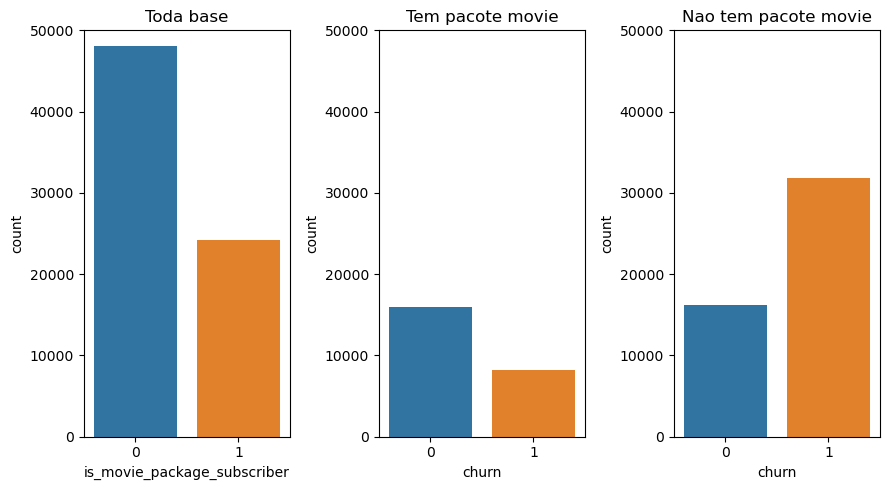

In [55]:
# 1.1 maioria das pessoas nao tem o pacote de filmes
# 1.2 quem tem o pacote de filmes é bem menos propenso a dar churn e quem nao tem tende a dar churn
f, ax = plt.subplots(1, 3, figsize=(9, 5))
sns.countplot(df.is_movie_package_subscriber, ax=ax[0])
ax[0].set_ylim(0, 50000)
ax[0].set_title('Toda base')
sns.countplot(df[df.is_movie_package_subscriber == 1].churn, ax=ax[1])
ax[1].set_ylim(0, 50000)
ax[1].set_title('Tem pacote movie')
sns.countplot(df[df.is_movie_package_subscriber == 0].churn, ax=ax[2])
ax[2].set_ylim(0, 50000)
ax[2].set_title('Nao tem pacote movie')
f.tight_layout()

In [147]:
# basicamente todo mundo que tem o movie package tem tv, mas isso nao funciona ao contrairo
df[df.is_movie_package_subscriber == 1].is_tv_subscriber.value_counts()

1    24183
0        2
Name: is_tv_subscriber, dtype: int64

Text(0.5, 1.0, 'Tem tv')

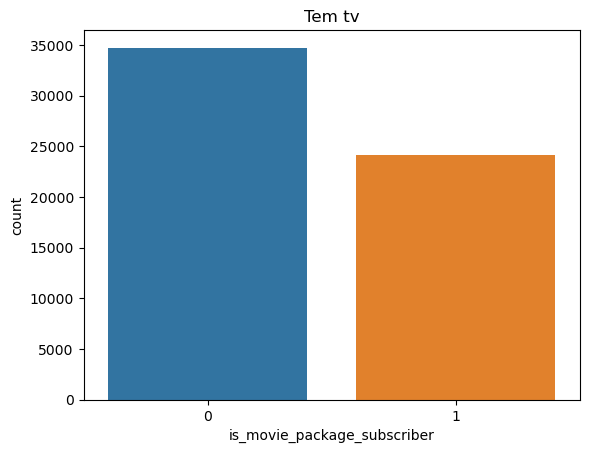

In [61]:
# a maior parte das pessoas q tem tv inclusive nao tem o movie package
g = sns.countplot(df[df.is_tv_subscriber == 1].is_movie_package_subscriber)
g.set_title('Tem tv')

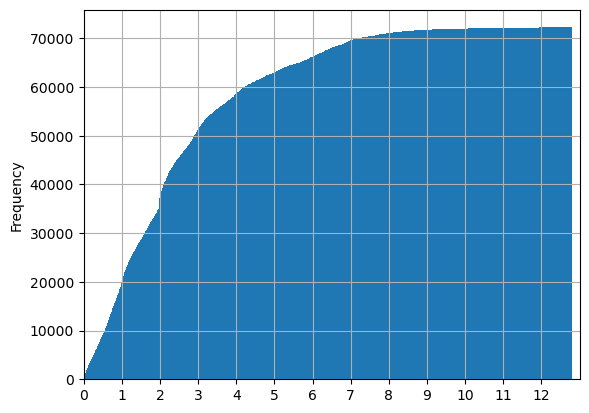

In [150]:
# distribuiçao acumulada do tempo de subscriçao do serviço
df['subscription_age'].plot(kind='hist', bins=1000, cumulative=True, grid=True)
plt.xlim(0,13)
plt.xticks(range(0,13))
plt.show()

In [77]:
p1a = df[df.subscription_age < 1].shape[0] / (df.shape[0]/100)
p2a = df[df.subscription_age < 2].shape[0] / (df.shape[0]/100)
p8a = df[df.subscription_age < 8].shape[0] / (df.shape[0]/100)
print('media do tempo de subscriçao dos clientes: %.2f anos' % (df.subscription_age.mean()))
print('%.0f clientes sao subscritos por menos de 1 ano que é equivente a %.2f%% de todos os clientes' % (df[df.subscription_age < 1].shape[0], p1a))
print('%.0f clientes sao subscritos por menos de 2 anos que é equivente a %.2f%% de todos os clientes' % (df[df.subscription_age < 2].shape[0], p2a))
print('%.0f clientes sao subscritos por menos de 8 anos que é equivente a %.2f%% de todos os clientes' % (df[df.subscription_age < 8].shape[0], p8a))

media do tempo de subscriçao dos clientes: 2.45 anos
19740 clientes sao subscritos por menos de 1 ano que é equivente a 27.31% de todos os clientes
37291 clientes sao subscritos por menos de 2 anos que é equivente a 51.60% de todos os clientes
71078 clientes sao subscritos por menos de 8 anos que é equivente a 98.35% de todos os clientes


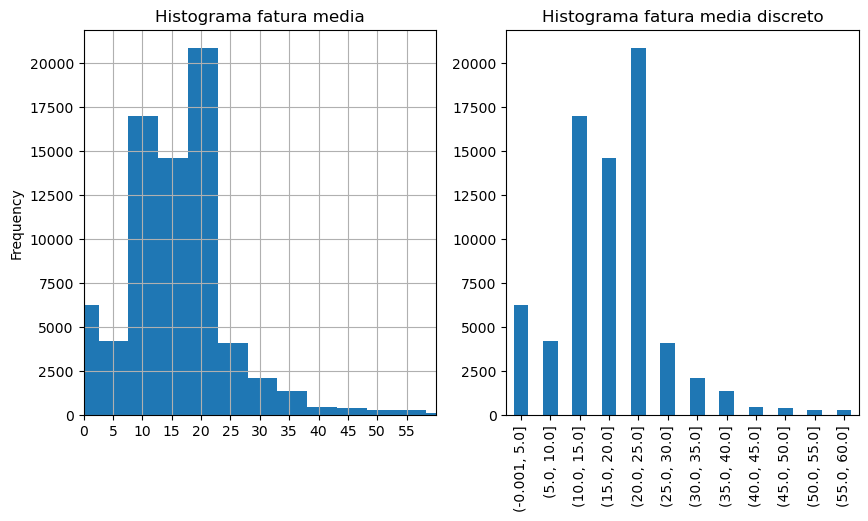

In [96]:
# grande maioria dos clientes paga entre 10 e 25, com pouquissimos clientes pagando valores majoritariamente relevantes
f, ax = plt.subplots(1, 2, figsize=(10, 5))

df.bill_avg.plot(kind='hist', bins=80, grid=True, align='left', ax=ax[0])
ax[0].set_xlim(0,60)
ax[0].set_xticks(range(0,60,5))
ax[0].set_title('Histograma fatura media')

step = 5
bin_range = np.arange(0, 60+step, step)
out = pd.cut(df.bill_avg, bins=bin_range, include_lowest=True)
out.value_counts().sort_index().plot.bar(ax=ax[1])
ax[1].set_title('Histograma fatura media discreto')

f2.tight_layout()

In [115]:
print('1.1 media do valor da fatura mensal é de %.2f$' % df.bill_avg.mean())
print('1.2 apenas %.2f%% dos clientes pagam mais que 40$ em sua fatura mensal' % (df[df.bill_avg > 40].shape[0] / (df.shape[0]/100)))
print('1.3 fatura media mais alta é de %.f$' % df.bill_avg.max())

1.1 media do valor da fatura mensal é de 18.94$
1.2 apenas 2.78% dos clientes pagam mais que 40$ em sua fatura mensal
1.3 fatura media mais alta é de 406$


In [ ]:
# Tentativa de estimar o faturamento da empresa em questao

In [134]:
bill = df.bill_avg.values
time = df.subscription_age.values
mes = 1/12

In [132]:
faturamento = 0
for i in range(df.shape[0]):
    faturamento += round(time[i]/mes) * bill[i]

In [145]:
meses_funcionamento = round(df.subscription_age.max()/mes) # aproximadamente a quantos meses a empresa tem suas info na base
print('Com os clientes dessa base é possivel estimar que nesses quase 13 anos a empresa faturou {0:,}$'.format(faturamento))
print('Aproximadamente {0:,}$ por mes'.format(int(faturamento/meses_funcionamento)))

Com os clientes dessa base é possivel estimar que nesses quase 13 anos a empresa faturou 41,831,128$
Aproximadamente 271,630$ por mes


In [154]:
# mas como observado anteriormente a base é uma amostra de uma base maior ainda
print("maior id:",df.id.max())
print("a base real é aproximadamente %.2f vezes maior" % (df.id.max() / df.shape[0]))

maior id: 1689744
a base real é aproximadamente 23.38 vezes maior


In [164]:
# 1.1 dados parecem terem sido coletados uniformemente, entao é possivel fazer uma Estimativa com E maiusculo de quanto a 
# ... empresa faturou nesses anos, apenas para brincar com os dados
print(df[df.id < 1000].shape[0], df[df.id < 2000].shape[0], df[df.id < 3000].shape[0], df[df.id < 4000].shape[0])
print(df[df.id < 10000].shape[0], df[df.id < 20000].shape[0], df[df.id < 30000].shape[0], df[df.id < 40000].shape[0])

46 100 140 181
455 875 1295 1718


In [177]:
# sendo um acaso poetico o numero é virtualmente 1bilhao quando entendemos a margem de erro enorme que estamos lidando
faturamento_estipulado = int(faturamento * df.id.max() / df.shape[0])
print('{0:,}$ em quase 13 anos'.format(faturamento_estipulado))
print('{0:,}$ por mes em media'.format(int(faturamento_estipulado / meses_funcionamento)))

977,998,969$ em quase 13 anos
6,350,642$ por mes em media


In [180]:
# 1.1 contratos podem chegar a quase 3 anos, porem a quantidade acima de 2 anos é totalmente despresivel, para efeitos praticos 
# ... eles sao de ate 2 anos
df.reamining_contract.max(), df[df.reamining_contract > 2].shape[0] # apenas 164 usuarios possuem contratos acima de 2 anos

(2.92, 164)

<AxesSubplot:>

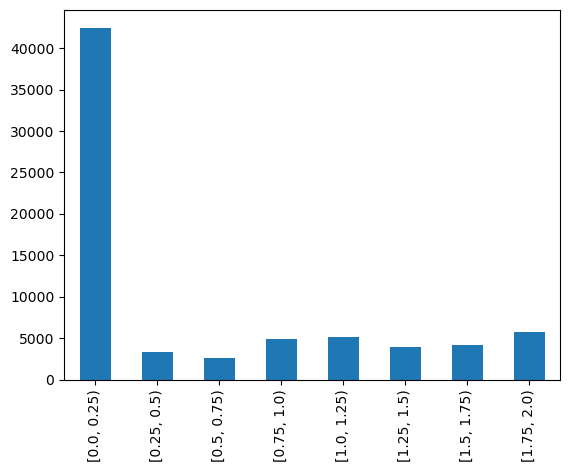

In [166]:
# olhando para a base toda a maioria dos contratos possui menos de 3 meses para acabar
step = 0.25
bin_range = np.arange(0, 2+step, step)
out2, bins2  = pd.cut(df.reamining_contract, bins=bin_range, include_lowest=True, right=False, retbins=True)
out2.value_counts().sort_index().plot.bar()

<AxesSubplot:>

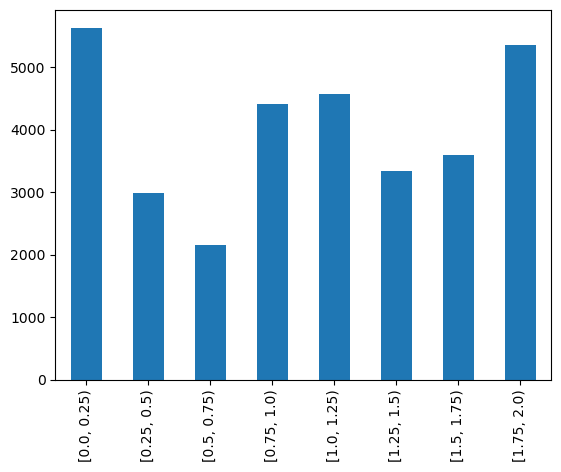

In [167]:
# 1.1 quando olhamos apenas para os clientes que ainda assinam o serviço, fica bem mais distribuido ao longo de 2 anos que 
# ... normalmente é o limite
step = 0.25
bin_range = np.arange(0, 2+step, step)
out2, bins2  = pd.cut(df[df.churn == 0].reamining_contract, bins=bin_range, include_lowest=True, right=False, retbins=True)
out2.value_counts().sort_index().plot.bar()

In [186]:
print("media de tempo de contrato restante dos clientes que ainda assinam: %.2f ano(s)" % df[df.churn == 0].reamining_contract.mean())
print("%.2f%% dos clientes ativos possuem seu contrato acabando em menos de 3 meses" % (df[df.churn == 0][df.reamining_contract < 0.25].shape[0] / (df[df.churn == 0].shape[0] / 100)))

media de tempo de contrato restante dos clientes que ainda assinam: 1.01 ano(s)
17.49% dos clientes ativos possuem seu contrato acabando em menos de 3 meses


<AxesSubplot:xlabel='service_failure_count', ylabel='count'>

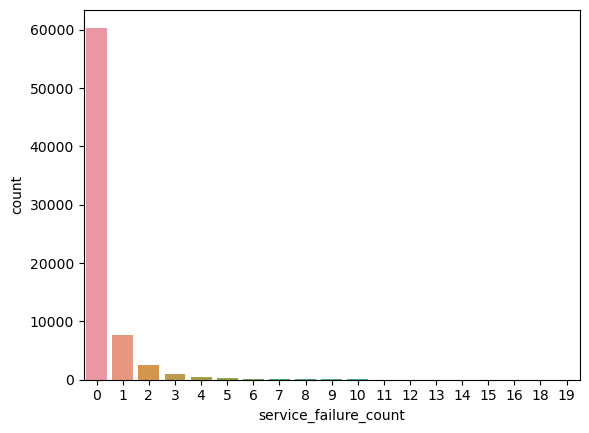

In [190]:
# pouquissimas pessoas ligam para reclamar dos serviços
sns.countplot(df.service_failure_count)

In [198]:
# aproximadamente 1 a cada 6 pessoas reclama dos serviços
df[df.service_failure_count > 0.5].shape[0], int(df.shape[0]/6) # pessoas que reclamaram pelo menos 1x , 1/6 da base

(11867, 12045)

In [212]:
# percebe-se que a ligaçao para reclamar por si só nao é um motivo que aumenta muito o churn dos clientes
print("porcentagem de churn de clientes que ja reclamaram: %.2f%%" % ((6686 / df[df.service_failure_count > 0.5].shape[0]) * 100))
print("porcentagem de churn de clientes que nunca reclamaram: %.2f%%" % ((33364 / df[df.service_failure_count < 0.5].shape[0]) * 100))

porcentagem de churn de clientes que ja reclamaram: 56.34%
porcentagem de churn de clientes que nunca reclamaram: 55.23%


In [216]:
print("media de download total: %.2f" % df.download_avg.mean())
print("media de download clientes ativos: %.2f" % df[df.churn == 0].download_avg.mean())
print("media de download clientes com churn: %.2f" % df[df.churn == 1].download_avg.mean())

media de download total: 43.46
media de download clientes ativos: 64.12
media de download clientes com churn: 26.84


In [5]:
df_churns = df[df.churn == 1]
df_ativos = df[df.churn == 0]

In [228]:
# 1.1 mais de 1/4 dos clientes que dao churn pouco usam(quando usam) a internet de download, enquanto os clientes ativos em sua 
# ... quase totalidade
print("Baixo uso de download entre os clientes que dao churn:")
print(df_churns[df_churns.download_avg < 1].shape[0], 'de', df_churns.shape[0])
print("Baixo uso de download entre os clientes que nao dao churn:")
print(df_ativos[df_ativos.download_avg < 1].shape[0], 'de', df_ativos.shape[0])

Baixo uso de download entre os clientes que dao churn:
11862 de 40050
Baixo uso de download entre os clientes que nao dao churn:
559 de 32224


In [7]:
# e seguindo a logica media de download segue mesmo padrao
print("media de upload total: %.2f" % df.upload_avg.mean())
print("media de upload clientes ativos: %.2f" % df[df.churn == 0].upload_avg.mean())
print("media de upload clientes com churn: %.2f" % df[df.churn == 1].upload_avg.mean())

media de upload total: 4.17
media de upload clientes ativos: 5.91
media de upload clientes com churn: 2.77


In [9]:
print("Baixo uso de upload entre os clientes que dao churn:")
print(df_churns[df_churns.upload_avg < 0.1].shape[0], 'de', df_churns.shape[0])
print("Baixo uso de upload entre os clientes que nao dao churn:")
print(df_ativos[df_ativos.upload_avg < 0.1].shape[0], 'de', df_ativos.shape[0])

Baixo uso de upload entre os clientes que dao churn:
11557 de 40050
Baixo uso de upload entre os clientes que nao dao churn:
498 de 32224


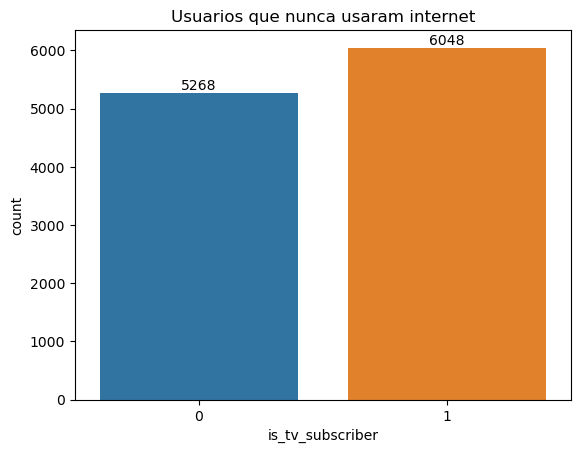

In [64]:
# 1.1 desses clientes que nao usam internet metade deles se quer possuem tv, o que leva a crer ou que nunca usufruiram dos
# ... serviços prestados, ou existe alguma anomalia nos dados
df_no_download = df[df.download_avg == 0]
df_no_internet = df_no_download[df_no_download.upload_avg == 0] 
g = sns.countplot(df_no_internet.is_tv_subscriber)
g.set_title("Usuarios que nunca usaram internet")
g.bar_label(g.containers[0])
plt.show()

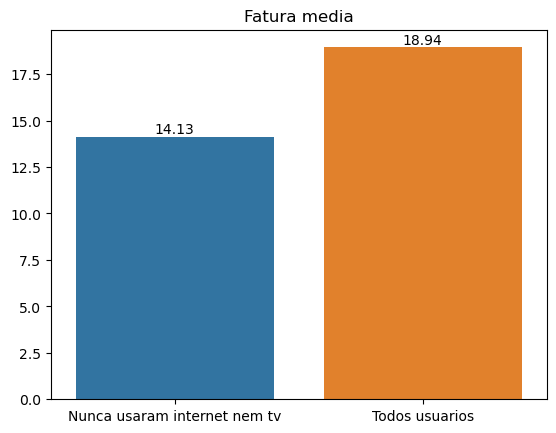

In [68]:
# como esses dados tem um valor de fatura media regular, é mais provavel que sejam apenas clientes que nunca usaram os serviços
array_g = [round(df_no_internet[df_no_internet.is_tv_subscriber == 0].bill_avg.mean(), 2), round(df.bill_avg.mean(), 2)]
g = sns.barplot(x=['Nunca usaram internet nem tv', 'Todos usuarios'], y=array_g)
g.bar_label(g.containers[0])
g.set_title('Fatura media')
plt.show()

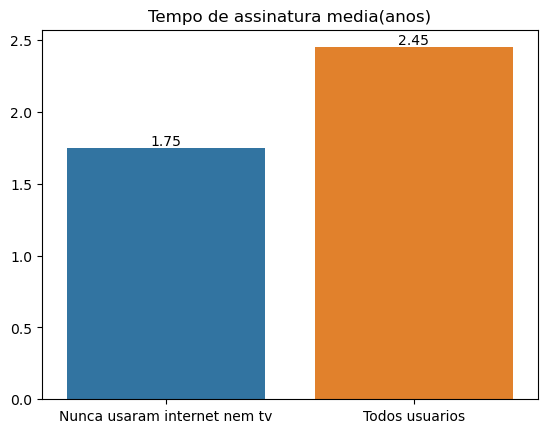

In [66]:
# esses clientes tambem possuem media significante de tempo de assinarua tambem
array_g = [round(df_no_internet[df_no_internet.is_tv_subscriber == 0].subscription_age.mean(), 2), round(df.subscription_age.mean(), 2)]
g = sns.barplot(x=['Nunca usaram internet nem tv', 'Todos usuarios'] , y=array_g)
g.bar_label(g.containers[0])
g.set_title('Tempo de assinatura media(anos)')
plt.show()

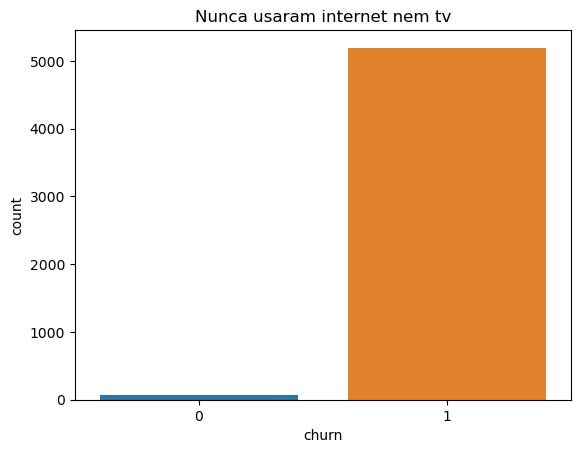

In [73]:
# mas sem muita surpresa, quase que a totalidade acaba dando churn
g = sns.countplot(df_no_internet[df_no_internet.is_tv_subscriber == 0].churn)
g.set_title('Nunca usaram internet nem tv')
plt.show()

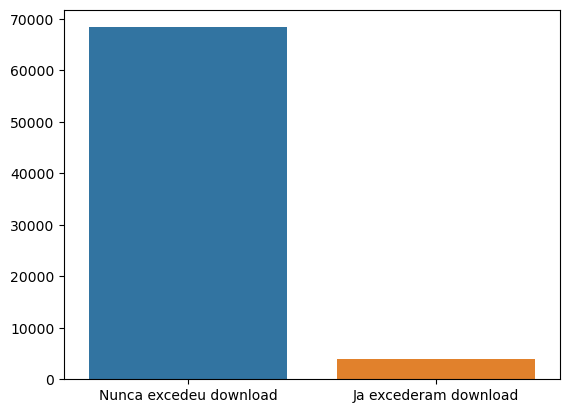

In [78]:
# rarissimos casos de pessoas que pagaram a mais por excesso de download nos ultimos 9 meses
g = sns.barplot(x=['Nunca excedeu download', 'Ja excederam download'], y=[df[df.download_over_limit < 0.5].shape[0], df[df.download_over_limit > 0.5].shape[0]])

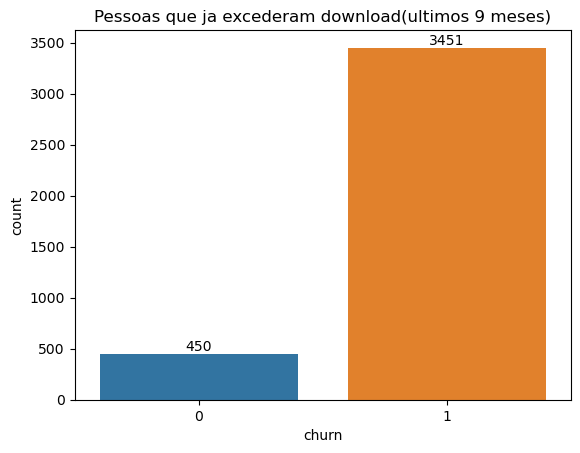

In [85]:
# porem bem expressivo que quem excede o download e paga mais, acaba por dar churn nos serviços
g = sns.countplot(df[df.download_over_limit > 0.5].churn)
g.set_title("Pessoas que ja excederam download(ultimos 9 meses)")
g.bar_label(g.containers[0])
plt.show()

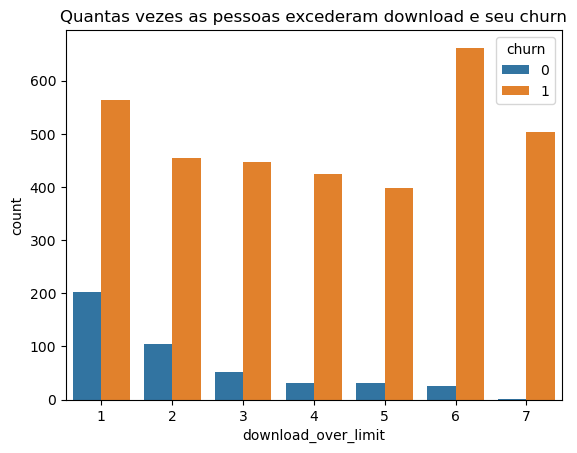

In [90]:
# nao conta as pessoas que nunca excederam o download
g = sns.countplot(data=df[df.download_over_limit > 0.5], x='download_over_limit', hue='churn')
g.set_title("Quantas vezes as pessoas excederam download e seu churn")
plt.show()

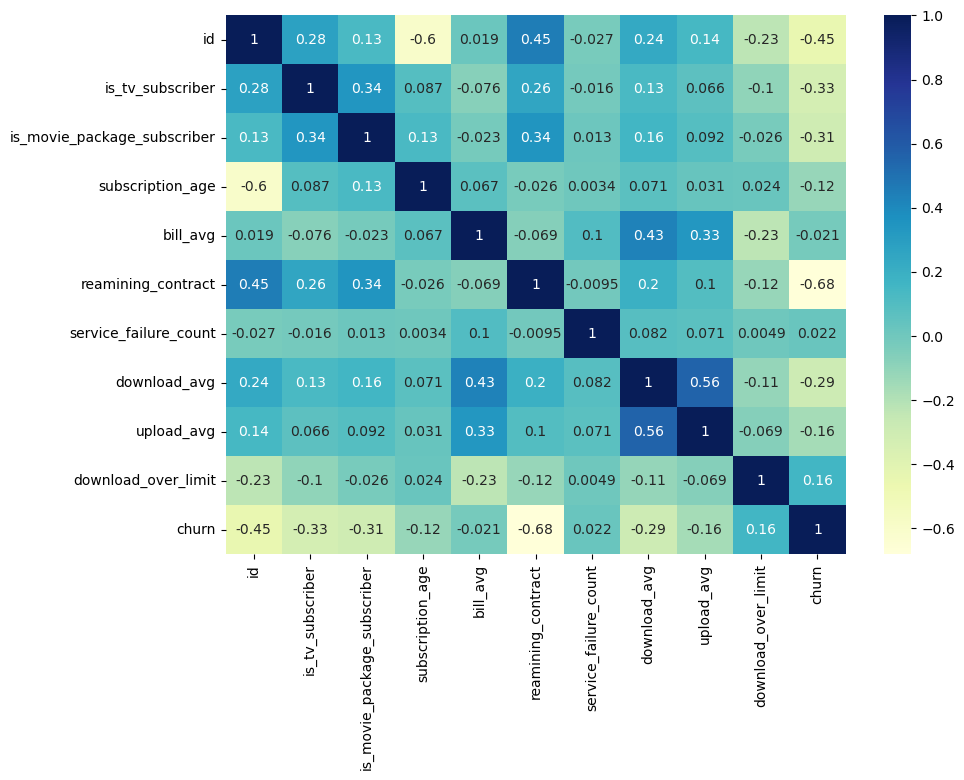

In [100]:
# grafico de correlaçoes
plt.figure(figsize=(10,7))
g = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
plt.show()

# Processamento dos dados para o modelo

In [5]:
df2 = df.copy()

In [6]:
df2 = df2.drop('id', axis=1)

In [7]:
# funçao usada para converter as colunas citadas abaixo
def convert(column):
    if column > 0.5:
        return 1
    else:
        return 0

In [8]:
# 1.1 como existem poucos casos desses eventos, resolvi agrupa-los como categoricas binarias de caso esses eventos aconteceram
# ... pelo menos 1x ou nunca aconteceram
df2['download_over_limit'] = df2['download_over_limit'].apply(convert)
df2['service_failure_count'] = df2['service_failure_count'].apply(convert)

In [9]:
var_b = df2.nunique()[df2.nunique() == 2].keys().tolist()

In [10]:
var_b # variaveis categoricas binarias

['is_tv_subscriber',
 'is_movie_package_subscriber',
 'service_failure_count',
 'download_over_limit',
 'churn']

In [11]:
var_n = [col for col in df2.columns.tolist() if col not in var_b]

In [12]:
var_n # variaveis numericas

['subscription_age',
 'bill_avg',
 'reamining_contract',
 'download_avg',
 'upload_avg']

In [13]:
# Label enconder nao é necessario devido a ausencia de variaveis categoricas binarias, que ja nao estejam em seu devido formato

In [14]:
# Nao sobraram variaveis categoricas nao binarias para serem usado dummies

In [16]:
sc = StandardScaler()

In [17]:
df3 = df2.copy()

In [18]:
# normalizando variaveis numericas
sc_data = df3[var_n]
scaled = sc.fit(sc_data.values)
sc_data = scaled.transform(sc_data.values)
df3[var_n] = sc_data

# Data split

In [17]:
df3

,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,1,0,4.67,0.46,-0.54,0,-0.55,-0.19,0,0
1,0,0,2.84,-1.43,-0.75,0,-0.69,-0.43,0,1
2,1,0,3.17,-0.22,-0.75,0,-0.47,-0.33,0,1
3,0,0,2.17,0.16,-0.75,1,-0.69,-0.43,0,1
4,0,0,1.94,-1.43,-0.75,0,-0.69,-0.43,0,1
...,...,...,...,...,...,...,...,...,...,...
72269,1,1,-1.16,-1.43,1.12,0,-0.69,-0.43,0,1
72270,1,0,-1.17,-1.36,1.68,0,-0.67,-0.43,0,1
72271,1,0,-1.19,-1.43,2.52,0,-0.66,-0.41,0,1
72272,0,0,-1.20,-1.43,0.33,0,-0.69,-0.43,0,1


In [19]:
data_model = df3.drop('churn', axis=1)
answer = df3['churn']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(data_model, answer, test_size=0.2, random_state=42)

# Modelos

In [22]:
rf = RandomForestClassifier()
svc = SVC()
lr = LogisticRegression()
knn = KNeighborsClassifier()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

In [23]:
models = [rf, svc, lr, knn, xgb, lgbm]

# Cross validation

In [25]:
%%time
# avaliando resultados previos dos modelos
cross_val_results = []
for model in models:
    kf = KFold(n_splits=5)
    acc = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
    roc_auc = cross_val_score(model, X_train, y_train, cv=kf, scoring='roc_auc')
    recall = cross_val_score(model, X_train, y_train, cv=kf, scoring='recall')
    cross_val_results.append([acc, roc_auc, recall])

Wall time: 19min 35s


In [50]:
models_names = ['rf', 'svc', 'lr', 'knn', 'xgb', 'lgbm']
cv_frame = pd.DataFrame(columns=['accuracy', 'roc_auc', 'recall'])
pd.set_option('display.float_format', lambda x: '%.4f' % x)
for i in cross_val_results:
    cv_frame.loc[len(cv_frame)] = i[0].mean(), i[1].mean(), i[2].mean()
cv_frame['model'] = models_names
cv_frame

,accuracy,roc_auc,recall,model
0,0.9396,0.9772,0.9354,rf
1,0.9104,0.9515,0.9243,svc
2,0.8712,0.9331,0.9179,lr
3,0.9059,0.9458,0.9084,knn
4,0.9415,0.9786,0.9404,xgb
5,0.9411,0.9788,0.9384,lgbm


In [56]:
# pelos resultados os modelos randomforest, xgb e lgbm se destacam dos demais, entao serao aprimorados mais a frente
cv_frame[cv_frame.accuracy > 0.93]

,accuracy,roc_auc,recall,model
0,0.9396,0.9772,0.9354,rf
4,0.9415,0.9786,0.9404,xgb
5,0.9411,0.9788,0.9384,lgbm


In [62]:
# medindo o tempo de execuçao dos melhores modelos
rft = RandomForestClassifier()
xgbt = XGBClassifier()
lgbmt = LGBMClassifier()

kft = KFold(n_splits=5)

In [63]:
%%time # RandomForest
cross_val_score(rft, X_train, y_train, cv=kft, scoring='accuracy')

Wall time: 25.9 s


array([0.9419751 , 0.93834313, 0.93860256, 0.93964026, 0.93972153])

In [64]:
%%time # XGB
cross_val_score(xgbt, X_train, y_train, cv=kft, scoring='accuracy')

Wall time: 5.85 s


array([0.94344517, 0.93972674, 0.94102387, 0.94162919, 0.94145118])

In [65]:
%%time # LightGBM
cross_val_score(lgbmt, X_train, y_train, cv=kft, scoring='accuracy')

Wall time: 1.27 s


array([0.9437046 , 0.93981321, 0.94145624, 0.94050502, 0.94006746])

# Definindo melhores parametros dos modelos

In [70]:
# padronizando quantidade de separaçoes da base para testes
kfo = KFold(n_splits=5)

## RandomForest

### Encontrando melhores parametros

In [71]:
%%time
param_grid_rf = {
            'max_depth': [5, 10, 15, 20],
            'n_estimators': [25, 50, 75, 100, 125],
            'max_features': ['auto', 'sqrt', 'log2']}
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid_rf, cv=kfo)
grid_result_rf = grid_search_rf.fit(X_train, y_train)

Wall time: 14min 20s


In [76]:
print(grid_result_rf.best_params_)
print('accuracy desses parametros:', grid_result_rf.best_score_)
print('accuracy default:', cross_val_results[0][0].mean())

{'max_depth': 20, 'max_features': 'log2', 'n_estimators': 100}
accuracy desses parametros: 0.9396392098953014
accuracy default: 0.9395527391143993


### Treinando modelo com os melhores parametros

In [129]:
model_rf = RandomForestClassifier(max_depth=20, max_features='log2', n_estimators=100)

In [130]:
%%time
model_rf.fit(X_train, y_train)

Wall time: 6.8 s


RandomForestClassifier(max_depth=20, max_features='log2')

In [131]:
pred_rf = model_rf.predict(X_test)

### Resultados do modelo

In [132]:
print(classification_report(y_test, pred_rf))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      6553
           1       0.95      0.94      0.95      7902

    accuracy                           0.94     14455
   macro avg       0.94      0.94      0.94     14455
weighted avg       0.94      0.94      0.94     14455



In [136]:
roc_rf = roc_auc_score(y_test, pred_rf)
roc_rf

0.9409555259621497

In [135]:
cm_rf = confusion_matrix(y_test, pred_rf)
cm_rf

array([[6188,  365],
       [ 493, 7409]], dtype=int64)

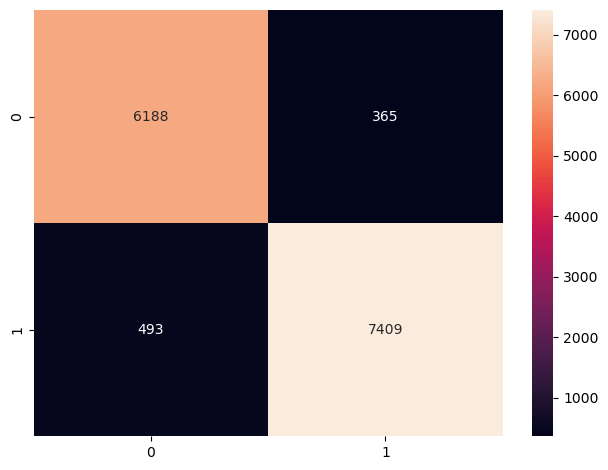

In [150]:
sns.heatmap(confusion_matrix(y_test, pred_rf), fmt='g', annot=True)
plt.tight_layout()
plt.show()

## XGB

### Encontrando melhores parametros

In [98]:
param_grid_xg = {
    'n_estimators': [50, 100, 200, 300],
    'gamma': [0, 1],
    'learning_rate': [0.03, 0.1, 0.3]}

In [99]:
%%time
grid_search_xg = GridSearchCV(xgb, param_grid=param_grid_xg, cv=kfo)
grid_result_xg = grid_search_xg.fit(X_train, y_train)

Wall time: 4min 8s


In [100]:
print(grid_result_xg.best_params_)
print('accuracy desses parametros:', grid_result_xg.best_score_)
print('accuracy default:', cross_val_results[4][0].mean())

{'gamma': 0, 'learning_rate': 0.1, 'n_estimators': 300}
accuracy desses parametros: 0.9419394849319744
accuracy default: 0.9414552309093824


### Treinando modelo com os melhores parametros

In [139]:
model_xgb = XGBClassifier(n_estimators=300, learning_rate=0.1, gamma=0)

In [140]:
%%time
model_xgb.fit(X_train, y_train)

Wall time: 4.82 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [141]:
pred_xgb = model_xgb.predict(X_test)

### Resultados do modelo

In [142]:
print(classification_report(y_test, pred_xgb))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      6553
           1       0.95      0.94      0.95      7902

    accuracy                           0.94     14455
   macro avg       0.94      0.94      0.94     14455
weighted avg       0.94      0.94      0.94     14455



In [144]:
roc_xgb = roc_auc_score(y_test, pred_xgb)
roc_xgb

0.9432110865349114

In [145]:
cm_xgb = confusion_matrix(y_test, pred_xgb)
cm_xgb

array([[6196,  357],
       [ 467, 7435]], dtype=int64)

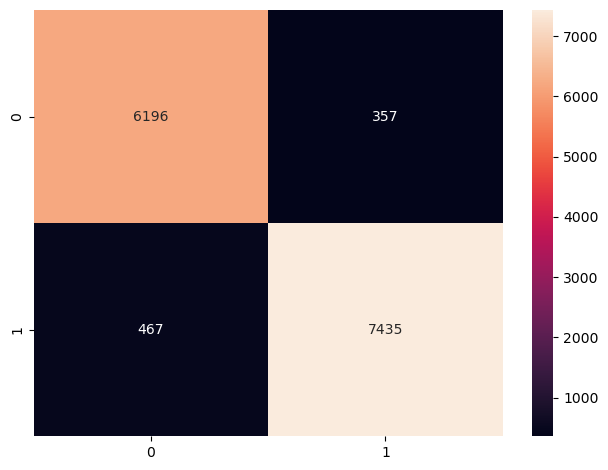

In [108]:
sns.heatmap(confusion_matrix(y_test, pred_xgb), fmt='g', annot=True)
plt.tight_layout()
plt.show()

## LightGBM

### Encontrando melhores parametros

In [116]:
param_grid_lgbm = {'max_depth':[-1,-3],
                   'num_leaves':[31, 50],
                   'learning_rate':[0.05, 0.1, 0.15],
                   'n_estimators':[75, 100, 125]
                 }

In [117]:
%%time
grid_search_lgbm = GridSearchCV(LGBMClassifier(), param_grid=param_grid_lgbm, cv=kfo)
grid_result_lgbm = grid_search_lgbm.fit(X_train, y_train)

Wall time: 58.5 s


In [119]:
print(grid_result_lgbm.best_params_)
print('accuracy desses parametros:', grid_result_lgbm.best_score_)
print('accuracy default:', cross_val_results[5][0].mean())

{'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 125, 'num_leaves': 50}
accuracy desses parametros: 0.9423372831309017
accuracy default: 0.9411093059055092


### Treinando modelo com os melhores parametros

In [108]:
model_lgbm = LGBMClassifier(n_estimators=125, learning_rate=0.1, max_depth=-1, num_leaves=50)

In [109]:
%%time
model_lgbm.fit(X_train, y_train)

Wall time: 370 ms


LGBMClassifier(n_estimators=125, num_leaves=50)

In [110]:
pred_lgbm = model_lgbm.predict(X_test)

### Resultados do modelo

In [147]:
print(classification_report(y_test, pred_lgbm))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      6553
           1       0.95      0.94      0.95      7902

    accuracy                           0.94     14455
   macro avg       0.94      0.94      0.94     14455
weighted avg       0.94      0.94      0.94     14455



In [148]:
roc_lgbm = roc_auc_score(y_test, pred_lgbm)
roc_lgbm

0.9437787086838957

In [149]:
cm_lgbm = confusion_matrix(y_test, pred_lgbm)
cm_lgbm

array([[6191,  362],
       [ 452, 7450]], dtype=int64)

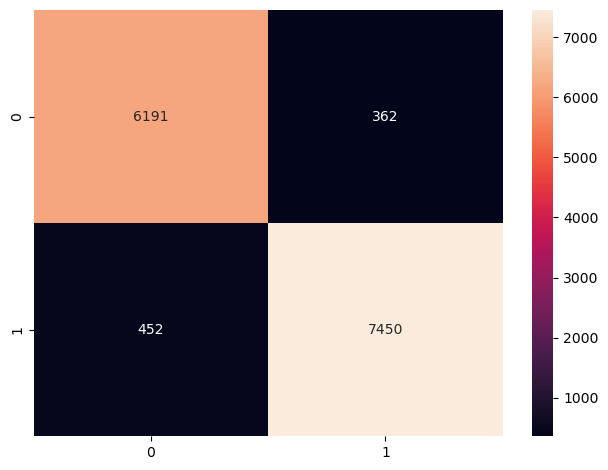

In [129]:
sns.heatmap(confusion_matrix(y_test, pred_lgbm), fmt='g', annot=True)
plt.tight_layout()
plt.show()

# Comparaçao de resultados

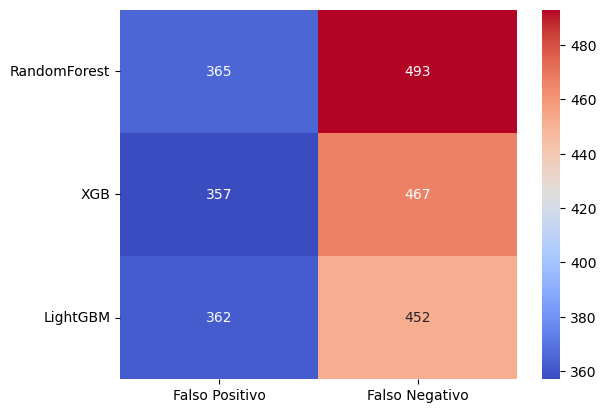

In [196]:
# 1.1 quanto menor melhor, cabe agora a avaliaçao se é mais prejudicial achar que um cliente dara churn quando na verdade ele 
# ... nao dara(nesse caso o melhor modelo seria o LightGBM) ou se é mais prejudicial errar ao nao identificar que um cliente 
# ... dara churn(que nesse caso o melhor modelo seria o XGB, porem muito proximo do LightGBM). RandomForest por mais que pontue
# ... abaixo de ambos outros nao fica tao atras e seria uma abordagem ok usa-lo em ambos os casos, principalmente se identificar
# ... incorretamente clientes que darao churn nao é um grande problema para o caso
final_results =[[cm_rf[0][1], cm_rf[1][0]], [cm_xgb[0][1], cm_xgb[1][0]], [cm_lgbm[0][1], cm_lgbm[1][0]]]
g = sns.heatmap(final_results, fmt='g', annot=True, cmap=sns.color_palette("coolwarm", 1000))
g.set_xticks([0.5,1.5], labels=['Falso Positivo', 'Falso Negativo'])
g.set_yticks([0.5,1.5,2.5], labels=['RandomForest','XGB','LightGBM'], rotation=0)
plt.show()

In [192]:
print("Area Under the Curve")
print("RandomForest:", round(roc_rf * 100, 3))
print("XGB:", round(roc_xgb * 100, 3))
print("LightGBM:", round(roc_lgbm * 100, 3))

Area Under the Curve
RandomForest: 94.096
XGB: 94.321
LightGBM: 94.378
